In [13]:
import csv
import pandas
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [2]:
# Definisi Fungsi Keanggotaan Fuzzy
def triangular_membership(x, a, b, c):
    return max(min((x-a)/(b-a), (c-x)/(c-b)), 0)

# Fuzzifikasi untuk satu input
def fuzzify_input(x, membership_functions):
    return [mf(x) for mf in membership_functions]

In [3]:
data = []

with open('dataset.csv', mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        data.append([float(row['current']), float(row['rawIntensity']), float(row['temperature']), float(row['voltage']), int(row['pwm'])])

data = numpy.array(data)

X_raw = data[:, :-1]
y = data[:, -1]

In [4]:
membership_functions = [
    lambda x: triangular_membership(x, 0, 25, 40),  # "current"
    lambda x: triangular_membership(x, 1000, 1010, 1020),  # "rawIntensity"
    lambda x: triangular_membership(x, 20, 25, 30),  # "temperature"
    lambda x: triangular_membership(x, 0.85, 0.9, 0.95)  # "voltage"
]

In [5]:
X_fuzzy = numpy.array([
    [fuzzify_input(x, membership_functions) for x in X_row] for X_row in X_raw
])

X_train, X_val, y_train, y_val = train_test_split(X_fuzzy.reshape(len(X_fuzzy), -1), y, test_size=0.2, random_state=42)


In [6]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\Users\atmatech\Documents\eps32_solarcell_anfis_mppt\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=4, verbose=1)


Epoch 1/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 11866.1221 - mae: 102.5946 - val_loss: 1106.6313 - val_mae: 28.8570
Epoch 2/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1122.1663 - mae: 29.5535 - val_loss: 1065.5599 - val_mae: 29.0128
Epoch 3/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1072.6486 - mae: 29.2669 - val_loss: 1043.2576 - val_mae: 29.0404
Epoch 4/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1058.1577 - mae: 29.4603 - val_loss: 1026.4781 - val_mae: 29.0195
Epoch 5/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1034.0458 - mae: 29.2638 - val_loss: 1015.0837 - val_mae: 28.9524
Epoch 6/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1015.7443 - mae: 29.1177 - val_loss: 1009.9528 - val_mae: 28.8876
Epoch 7/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1005.9527 - mae: 28.9450 - val_loss: 998.3376 - val_mae: 28.9588
Epoch 8/50
671/671 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 999.6506 - mae: 29.1062 - val_loss: 995.0717 - val_mae: 2

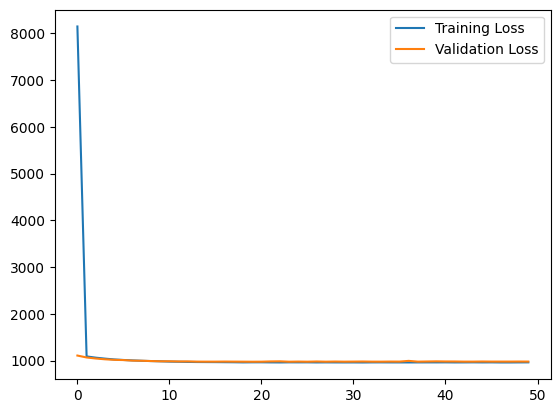

In [8]:
# Step 6: Plot Hasil
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [14]:
y_pred = model.predict(X_val)

# Menghitung metrik evaluasi
mse = mean_squared_error(y_val, y_pred)
rmse = numpy.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error (MSE): 977.4010
Root Mean Squared Error (RMSE): 31.2634
Mean Absolute Error (MAE): 28.9916
R-squared (R2): 0.0255


In [10]:
model.save('model.h5')

In [11]:
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\atmatech\AppData\Local\Temp\tmpag8fdw9w\assets


INFO:tensorflow:Assets written to: C:\Users\atmatech\AppData\Local\Temp\tmpag8fdw9w\assets


Saved artifact at 'C:\Users\atmatech\AppData\Local\Temp\tmpag8fdw9w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2595996212432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2595996216080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2595996214928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2595996213776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2595996216656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2595996214352: TensorSpec(shape=(), dtype=tf.resource, name=None)
